# Discussion of the GP marginal likelihood upper bound

See the [`gp_upper` repository](https://github.com/markvdw/gp_upper) for code to tighten the upper bound through optimisation, and a more comprehensive discussion.

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

import numpy as np
import tensorflow as tf

import gpflow
from gpflow.utilities import set_trainable, print_summary
from gpflow.ci_utils import ci_niter

import logging
logging.disable(logging.WARNING)

from FITCvsVFE import getTrainingTestData

In [2]:
X, Y, Xt, Yt = getTrainingTestData()

In [3]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.feature.Z.value, m.feature.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = m.log_likelihood().numpy()
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

### Full model

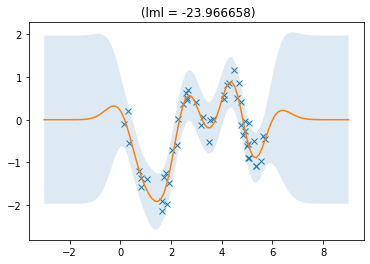

In [4]:
f = gpflow.models.GPR((X, Y), gpflow.kernels.SquaredExponential())
objective = tf.function(f.neg_log_marginal_likelihood)
gpflow.optimizers.Scipy().minimize(objective, f.trainable_variables, options=dict(maxiter=ci_niter(1000)))
full_lml = plot_model(f)

### Upper bounds for sparse variational models
As a first investigation, we compute the upper bound for models trained using the sparse variational GP approximation.

In [8]:
Ms = np.arange(4, ci_niter(20, test_n=6), 1)
vfe_lml = []
vupper_lml = []
vfe_hyps = []
for M in Ms:
    Zinit = X[:M, :].copy()
    vfe = gpflow.models.SGPR((X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=Zinit)
    objective = tf.function(autograph=False)(vfe.neg_log_marginal_likelihood)
    gpflow.optimizers.Scipy().minimize(objective, vfe.trainable_variables, method='BFGS',
                                       options=dict(disp=False, maxiter=ci_niter(1000)))
    
    vfe_lml.append(vfe.log_likelihood().numpy())
    vupper_lml.append(vfe.upper_bound().numpy())
    vfe_hyps.append({p.name: p.read_value() for p in vfe.trainable_parameters})
    print("%i" % M, end=" ")

4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

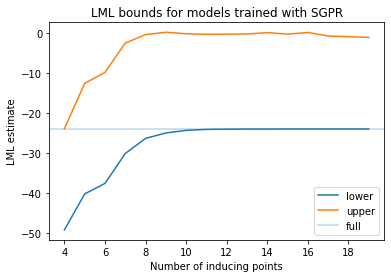

In [9]:
plt.title("LML bounds for models trained with SGPR")
plt.plot(Ms, vfe_lml, label="lower")
plt.plot(Ms, vupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend();

We see that the lower bound increases as more inducing points are added. Note that the upper bound does _not_ monotonically decrease! This is because as we train the sparse model, we also get better estimates of the hyperparameters. The upper bound will be different for this different setting of the hyperparameters, and is sometimes looser. The upper bound also converges to the true lml slower than the lower bound.

### Upper bounds for fixed hyperparameters
Here, we train sparse models with the hyperparameters fixed to the optimal value found previously.

In [12]:
fMs = np.arange(3, ci_niter(20, test_n=5), 1)
fvfe_lml = []  # Fixed vfe lml
fvupper_lml = []  # Fixed upper lml
for M in fMs:
    Zinit = vfe.inducing_variable.Z.numpy()[:M, :]
    Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
    
    init_params = [p.numpy() for p in vfe.trainable_parameters]  # TODO: provide convenience function
    
    vfe = gpflow.models.SGPR((X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=Zinit)
    
    # copy hyperparameters from optimised model:
    [p.assign(val) for p, val in zip(vfe.trainable_parameters, init_params)
                   if p is not vfe.inducing_variable.Z]
    # keep our own augmented set of inducing point locations:
    vfe.inducing_variable.Z = gpflow.Parameter(Zinit, dtype=gpflow.default_float())
    
    set_trainable(vfe.kernel, False)
    set_trainable(vfe.likelihood, False)
    
    objective = tf.function(autograph=False)(vfe.neg_log_marginal_likelihood)
    gpflow.optimizers.Scipy().minimize(objective, vfe.trainable_variables,
                                       options=dict(disp=False, maxiter=ci_niter(1000)))
    
    fvfe_lml.append(vfe.log_likelihood().numpy())
    fvupper_lml.append(vfe.upper_bound().numpy())
    print("%i" % M, end=" ")

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

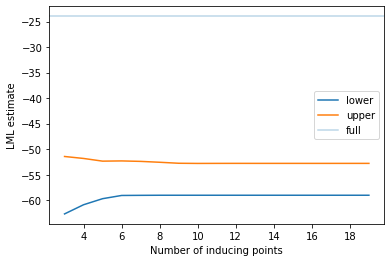

In [13]:
plt.plot(fMs, fvfe_lml, label="lower")
plt.plot(fMs, fvupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend();

Now, as the hyperparameters are fixed, the bound _does_ monotonically decrease. We chose the optimal hyperparameters here, but the picture should be the same for any hyperparameter setting. This shows that we increasingly get a better estimate of the marginal likelihood as we add more inducing points.

### A tight estimate bound does not imply a converged model

In [14]:
single_inducing_point = X[:1, :].copy()
vfe = gpflow.models.SGPR((X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=single_inducing_point)
objective = tf.function(autograph=False)(vfe.neg_log_marginal_likelihood)
gpflow.optimizers.Scipy().minimize(objective, vfe.trainable_variables,
                                   options=dict(maxiter=ci_niter(1000)))

print("Lower bound: %f" % vfe.log_likelihood().numpy())
print("Upper bound: %f" % vfe.upper_bound().numpy())

Lower bound: -65.059355
Upper bound: -65.059223


In this case we show that for the hyperparameter setting, the bound is very tight. However, this does _not_ imply that we have enough inducing points, but simply that we have correctly identified the marginal likelihood for this particular hyperparameter setting. In this specific case, where we used a single inducing point, the model collapses to not using the GP at all (lengthscale is really long to model only the mean). The rest of the variance is explained by noise. This GP can be perfectly approximated with a single inducing point.

In [15]:
print_summary(vfe, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,True,(),float64,2.2252131171029327e-07
SGPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.5465223446319287
SGPR.likelihood.variance,Parameter,Softplus,True,(),float64,0.7901734712434755
SGPR.inducing_variable.Z,Parameter,,True,"(1, 1)",float64,[[15.5547125]]


This can be diagnosed by showing that there are other hyperparameter settings with higher upper bounds. This indicates that there may be better hyperparameter settings, but we cannot identify them due to the lack of inducing points. An example of this can be seen in the previous section.